In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
import sys
sys.path.append('../src')

In [4]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import seaborn as sns
import torch
import pandas as pd
import spaceoracle
from spaceoracle import SpaceOracle

In [5]:
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score

In [6]:
adata_train = sc.read_h5ad('.cache/adata_train.h5ad')
adata_train

AnnData object with n_obs × n_vars = 11567 × 5013
    obs: 'cluster', 'rctd_cluster', 'rctd_celltypes'
    uns: 'log1p'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [7]:
from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator

In [8]:
from spaceoracle.models.pixel_attention import CellularNicheNetwork

In [9]:
from spaceoracle.tools.utils import search

In [112]:
estimator = SpatialCellularProgramsEstimator(
    adata=adata_train,
    target_gene='Tlcd2',
)

In [ ]:
%%time

estimator.fit(num_epochs=500, threshold_lambda=1e-4, learning_rate=1e-3)

In [113]:
%%time

estimator.fit(num_epochs=100, threshold_lambda=1e-4, learning_rate=1e-3)

Fitting Tlcd2 with 404 modulators
	103 Transcription Factors
	27 Ligand-Receptor Pairs
	274 TranscriptionFactor-Ligand Pairs
0: 0.1554 | 0.1889
1: 0.4058 | 0.5262
2: 0.3665 | 0.4376
3: 0.6028 | 0.8392
4: 0.5417 | 0.7969
5: 0.6682 | 0.8844
6: 0.8337 | 0.9756
CPU times: user 2min 42s, sys: 23.7 s, total: 3min 5s
Wall time: 4min 23s


In [104]:
df = estimator.betadata

In [107]:
c = 2
df2 = pd.DataFrame(df[df.rctd_cluster==c][[i for i in df.columns if 'beta_' in i]].mean(0), 
        columns=['beta']).sort_values('beta', ascending=False)
df2 = df2.loc[['beta_'+i for i in estimator.modulators]]
df2['lasso'] = estimator.models[c].anchors.cpu().numpy()[1:]
df2.loc['beta_Pax5']

beta     0.234729
lasso    0.191883
Name: beta_Pax5, dtype: float32

In [98]:
df[df.rctd_cluster==0]['beta_Pax5'].mean()

0.09800263066600143

In [99]:
df[df.rctd_cluster==1]['beta_Pax5'].mean()


0.21635278515555695

In [100]:
df[df.rctd_cluster==2]['beta_Pax5'].mean()


0.2347287409172041

beta     0.098015
lasso    0.123798
Name: beta_Pax5, dtype: float32

In [88]:
sns.scatterplot(
    data=df2.loc[np.intersect1d(df2.index, ['beta_'+i for i in estimator.tfl_pairs])][df2['lasso']!=0],
    x='lasso',
    y='beta'
)
plt.show()

In [48]:
estimator.betadata.to_parquet(f'./models/{estimator.target_gene}_betadata.parquet')

In [49]:
# df = estimator.betadata
# betas = torch.from_numpy(
#     df[['beta0']+['beta_'+i for i in estimator.modulators]].values).float()

# inputs_x = torch.from_numpy(
#     estimator.train_df.drop(
#         columns=estimator.target_gene).values).float()

In [50]:
# plt.rcParams['figure.figsize'] = (25, 3)
# plt.rcParams['figure.dpi'] = 120

# hmap = df[[
#         'beta_'+i for i in estimator.modulators if '#' not in i and '$' not in i]+[
#             'rctd_celltypes']].groupby('rctd_celltypes').mean().abs()>0
# sns.heatmap(
#     hmap.loc[:, (hmap.sum(0) > 0)],
#     square=True,
#     cbar=False,
#     linewidths=0.5,
#     linecolor='black',
#     xticklabels=True,
#     yticklabels=True,
#     cmap='Reds'
# )
# plt.title(f'Modulators for {estimator.target_gene}', fontsize=15)
# plt.tight_layout()
# plt.show()

# plt.rcParams['figure.figsize'] = (25, 5)
# hmap = df[[
#         'beta_'+i for i in estimator.modulators if '$' in i]+[
#             'rctd_celltypes']].groupby('rctd_celltypes').mean().abs()>0
# sns.heatmap(
#     hmap.loc[:, (hmap.sum(0) > 0)],
#     square=True,
#     cbar=False,
#     linewidths=0.5,
#     linecolor='black',
#     xticklabels=True,
#     yticklabels=True,
#     cmap='Reds'
# )
# plt.title(f'Modulators for {estimator.target_gene}', fontsize=15)
# plt.tight_layout()
# plt.show()
# hmap = df[[
#         'beta_'+i for i in estimator.modulators if '#' in i]+[
#             'rctd_celltypes']].groupby('rctd_celltypes').mean().abs()>0
# sns.heatmap(
#     hmap.loc[:, (hmap.sum(0) > 0)],
#     square=True,
#     cbar=False,
#     linewidths=0.5,
#     linecolor='black',
#     xticklabels=True,
#     yticklabels=True,
#     cmap='Reds'
# )

# plt.title(f'Modulators for {estimator.target_gene}', fontsize=15)
# plt.tight_layout()
# plt.show()

In [51]:
# y_pred = CellularNicheNetwork.predict_y(inputs_x, betas)

# r2_score(
#     estimator.train_df[estimator.target_gene], 
#     y_pred.cpu().numpy()
# )

In [52]:
cmaps = dict(zip(range(7), ['rainbow', 'hot', 'cool_r', 'spring', 'viridis', 'PuRd', 'Reds']))


In [62]:
gex_df['Pax5'].max()

1.9324267

In [64]:
from spaceoracle.oracles import SpaceOracle
from spaceoracle.tools.utils import min_max_df

so = SpaceOracle(adata=adata_train)
beta_dict = {estimator.target_gene: so._get_betas(estimator.target_gene)}

gex_df = min_max_df(estimator.adata.to_df(layer=estimator.layer))
beta_dict = so._get_wbetas_dict(beta_dict, gex_df, n_jobs=1)
wbetas = beta_dict[estimator.target_gene].wbetas


# reformat betas so it's the same as when plot method was written
xy = pd.DataFrame(
    adata_train.obsm['spatial'], index=adata_train.obs.index, columns=['x', 'y'])

df = wbetas \
        .join(adata_train.obs) \
        .join(xy) \
        .join(gex_df)

df

  0%|          | 0/1 [00:00<?, ?it/s]

beta_Angptl2  beta_Angptl4  beta_Atf3  beta_Bcl11a  \
AAAAAACGGTAGAT      0.000000      0.011057   0.000000     0.157993   
AAAAAATCCGGCGA      0.001056      0.001169   0.002354     0.185816   
AAAAACCGTCAGAC      0.000000      0.010776   0.000000     0.156683   
AAAAACGCTCCGAC      0.000000      0.002422   0.000000     0.158478   
AAAAAGCACGTGTT      0.000000      0.008659   0.000000     0.156200   
...                      ...           ...        ...          ...   
TTTTTTCGCGGCTA      0.002279      0.009446   0.003504     0.190185   
TTTTTTGGGCTGGT      0.001384      0.002968   0.000000     0.162174   
TTTTTTGTACCCAC      0.000758      0.001853   0.000000     0.161479   
TTTTTTGTACGATT      0.000000      0.002635   0.000000     0.158787   
TTTTTTTTGCTTTA      0.000000      0.005586   0.000000     0.157636   

                beta_Bcl11b   beta_C3  beta_C4b  beta_Cebpb  beta_Clcf1  \
AAAAAACGGTAGAT    -0.203433  0.006225  0.002729    0.023071    0.012268   
AAAAAATCCGGCGA     0.000301 -0.000057  0.000063   -0.010478   -0.000615   
AAAAACCGTCAGAC    -0.200873  0.021530  0.009535    0.022799    0.001585   
AAAAACGCTCCGAC    -0.203320  0.014158  0.006264    0.023060    0.001556   
AAAAAGCACGTGTT    -0.200134  0.012612  0.005569    0.022724    0.003499   
...                     ...       ...       ...         ...         ...   
TTTTTTCGCGGCTA    -0.000254 -0.000758  0.000582   -0.008886   -0.000963   
TTTTTTGGGCTGGT    -0.031530  0.000209  0.000385    0.017444    0.000000   
TTTTTTGTACCCAC    -0.031286  0.000330  0.000609    0.017313    0.000000   
TTTTTTGTACGATT    -0.203429  0.009924  0.004348    0.023151    0.006484   
TTTTTTTTGCTTTA    -0.202696  0.014894  0.006537    0.022990    0.001858   

                    beta_Cr2  ...    Zswim1    Zswim3    Zswim4    Zswim6  \
AAAAAACGGTAGAT  3.471626e-05  ...  0.097589  0.421042  0.176841  0.131493   
AAAAAATCCGGCGA  3.882842e-07  ...  0.000000  0.389565  0.188951  0.196777   
AAAAACCGTCAGAC  3.862518e-05  ...  0.493399  0.274746  0.176841  0.586356   
AAAAACGCTCCGAC  3.565340e-05  ...  0.493399  0.274746  0.188951  0.314296   
AAAAAGCACGTGTT  5.316912e-05  ...  0.682703  0.274746  0.000000  0.313466   
...                      ...  ...       ...       ...       ...       ...   
TTTTTTCGCGGCTA -6.335435e-07  ...  0.259127  0.274746  0.000000  0.179997   
TTTTTTGGGCTGGT  7.065085e-06  ...  0.000000  0.389565  0.365792  0.280179   
TTTTTTGTACCCAC  7.910624e-06  ...  0.121475  0.274746  0.176841  0.206385   
TTTTTTGTACGATT  2.779265e-05  ...  0.120031  0.274746  0.000000  0.178278   
TTTTTTTTGCTTTA  4.918277e-05  ...  0.618684  0.175016  0.179181  0.363042   

                  Zswim9      Zup1      Zw10    Zwilch      Zxdc     Zzef1  
AAAAAACGGTAGAT  0.000000  0.472964  0.564513  0.679694  0.512763  0.475320  
AAAAAATCCGGCGA  0.232299  0.551113  0.397646  0.633051  0.673578  0.476067  
AAAAACCGTCAGAC  0.397738  0.223781  0.277076  0.389925  0.227259  0.549043  
AAAAACGCTCCGAC  0.177184  0.310542  0.415657  0.272793  0.520555  0.438414  
AAAAAGCACGTGTT  0.177184  0.268726  0.641424  0.583910  0.432878  0.547513  
...                  ...       ...       ...       ...       ...       ...  
TTTTTTCGCGGCTA  0.000000  0.399256  0.361111  0.565977  0.678025  0.336376  
TTTTTTGGGCTGGT  0.191453  0.429524  0.326576  0.633051  0.516638  0.728582  
TTTTTTGTACCCAC  0.000000  0.579687  0.561819  0.614170  0.439503  0.631251  
TTTTTTGTACGATT  0.165439  0.262309  0.260203  0.556804  0.442145  0.538908  
TTTTTTTTGCTTTA  0.165439  0.450215  0.503458  0.464106  0.464827  0.418939  

[11567 rows x 5090 columns]

In [95]:
markers = ['o', 'X', '<', '^', 'v', 'D', '>']
cmaps = dict(zip(range(7), ['rainbow', 'cool', 'RdYlGn_r', 'spring_r', '', 'PuRd', 'Reds']))
cell_map = dict(zip(df['rctd_cluster'], df['rctd_celltypes']))

def plot(plot_for, clusters=[0, 1, 2], with_expr=False, size=25, linewidth=0.5, alpha=1, edgecolor='black', dpi=100, figsize=(11, 9), fig=None, axes=None):

    if fig is None or axes is None:
        fig, (ax, cax) = plt.subplots(1, 2, dpi=dpi, figsize=figsize, gridspec_kw={'width_ratios': [4, 0.5]})
    else:
        ax, cax = axes

    # Get cluster-specific min/max for individual colorbar scales
    norms = {}
    for i in clusters:
        cluster_data = df[df.rctd_cluster==i][plot_for]
        vmin = cluster_data.min()
        vmax = cluster_data.max()
        norms[i] = plt.Normalize(vmin=vmin, vmax=vmax)

    for i in clusters:
        betas_df = df[df.rctd_cluster==i]
        missing_columns = list(set(estimator.train_df.columns) - set(betas_df.columns))
        betas_df = betas_df.join(estimator.train_df[missing_columns])

        if with_expr:
            betas_df[plot_for] = betas_df[plot_for]*betas_df[plot_for.replace('beta_', '')]

        sns.scatterplot(
            data=betas_df,
            x='x', 
            y='y',
            hue=plot_for,
            palette=cmaps[i],
            s=size,
            alpha=alpha,
            linewidth=linewidth,
            edgecolor=edgecolor,
            legend=False,
            style='rctd_celltypes',
            markers=markers,
            ax=ax
        )
    ax.axis('off')

    cbar_width = 0.15  # Width of each colorbar
    cbar_height = 0.8 / len(cmaps)  # Height of each colorbar
    for i, cmap_name in cmaps.items():
        if i not in [0, 1, 2]:
            continue
        cmap = plt.get_cmap(cmap_name)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norms[i])
        sm.set_array([])
        cax_i = cax.inset_axes([0.2, 0.95 - (i+1)*cbar_height*2.5, cbar_width, cbar_height*1.5])
        cbar = fig.colorbar(sm, cax=cax_i, orientation='vertical')
        cbar.ax.tick_params(labelsize=9)  # Reduce tick label size
        cbar.ax.set_title(f'{cell_map[i]}', fontsize=12, pad=8)  # Reduce title size and padding

    cax.set_ylabel(plot_for, fontsize=8)
    cax.axis('off')

    unique_styles = sorted(set(df['rctd_celltypes']))
    style_handles = [plt.Line2D([0], [0], marker=m, color='w', markerfacecolor='gray', 
                    markersize=10, linestyle='None', alpha=1) 
                    for m in markers][:len(unique_styles)]
    ax.legend(style_handles, unique_styles, ncol=1,
        title='Cell types', loc='lower left',  
        frameon=False)

    ax.set_title(f'{plot_for} > {estimator.target_gene}', fontsize=15)
    
    return ax

In [96]:
plot('beta_Pax5', dpi=100, size=20, with_expr=False)

<Axes: title={'center': 'beta_Pax5 > Cd74'}, xlabel='x', ylabel='y'>

In [97]:
plot('beta_Pax5', dpi=100, size=20, with_expr=True)

<Axes: title={'center': 'beta_Pax5 > Cd74'}, xlabel='x', ylabel='y'>

<Axes: title={'center': 'Il2ra > Cd74'}, xlabel='x', ylabel='y'>

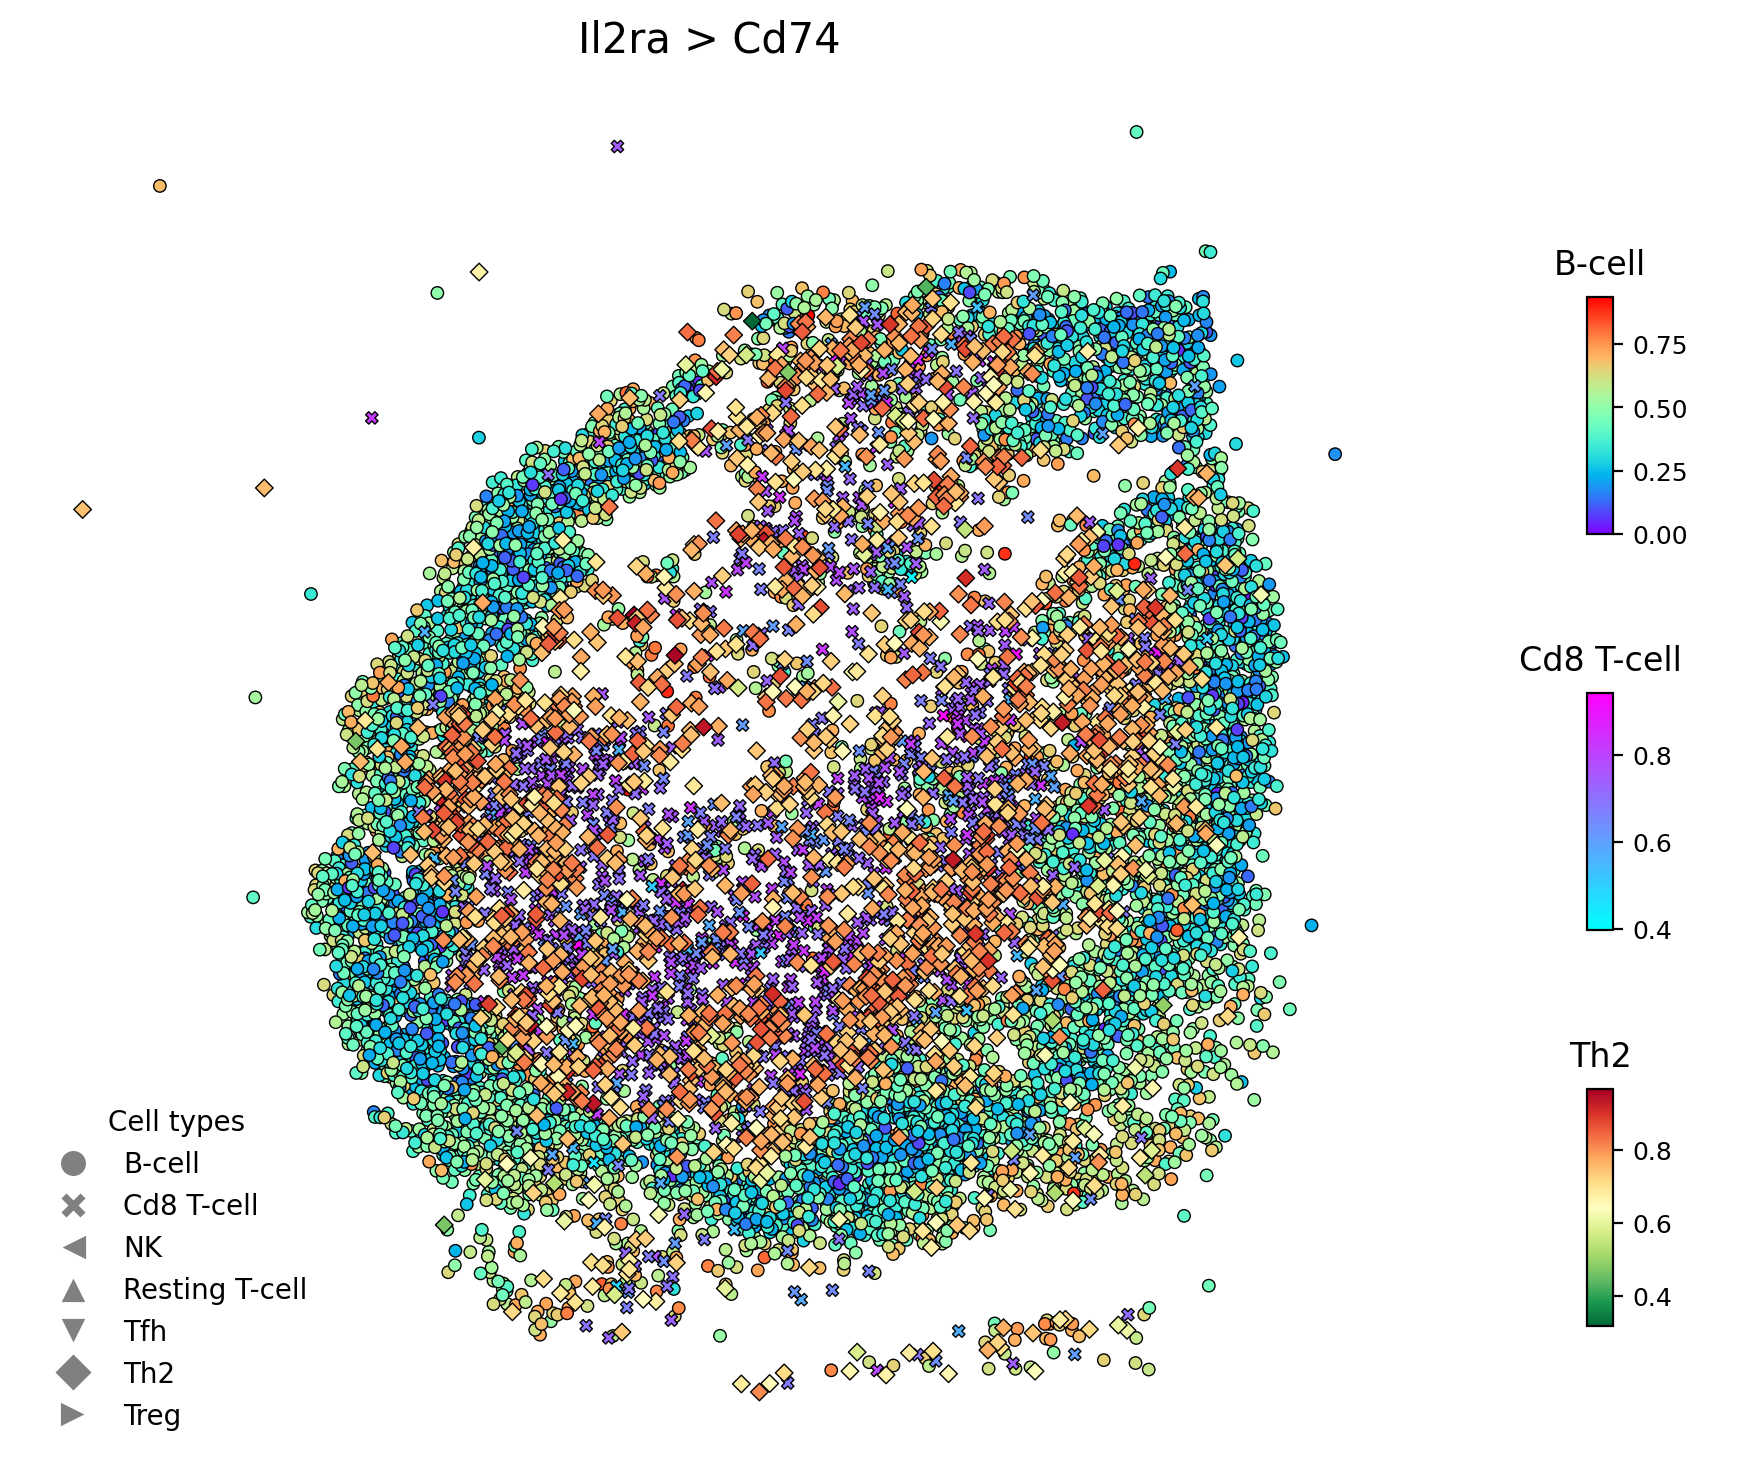

In [73]:
plot('Il2ra', dpi=100, size=20)

<Axes: title={'center': 'beta_Il2ra > Cd74'}, xlabel='x', ylabel='y'>

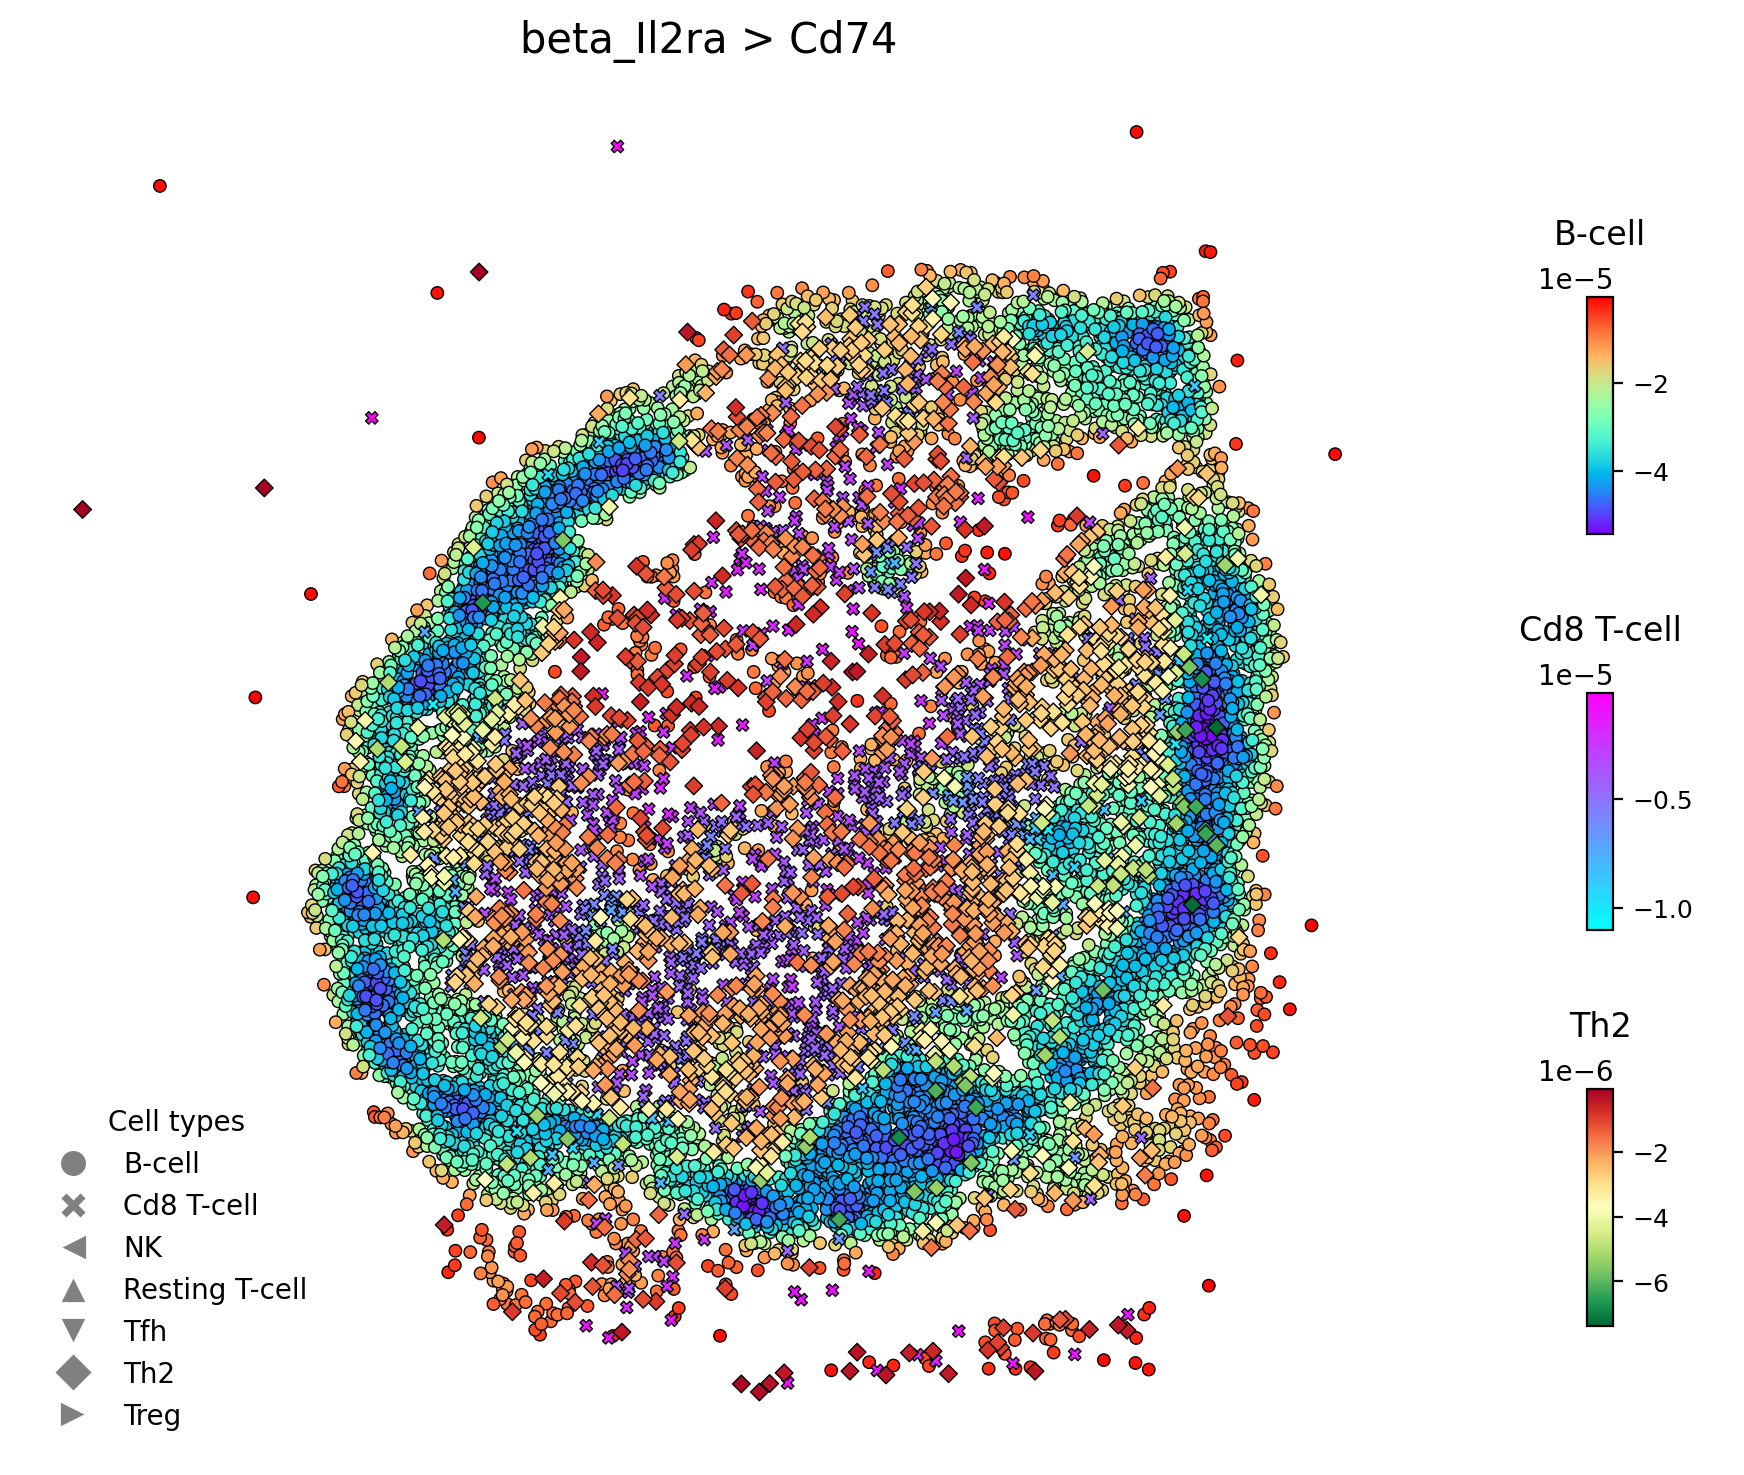

In [74]:
plot('beta_Il2ra', dpi=100, size=20)

ValueError: Could not interpret value `beta_Il2#Egr2` for `hue`. An entry with this name does not appear in `data`.

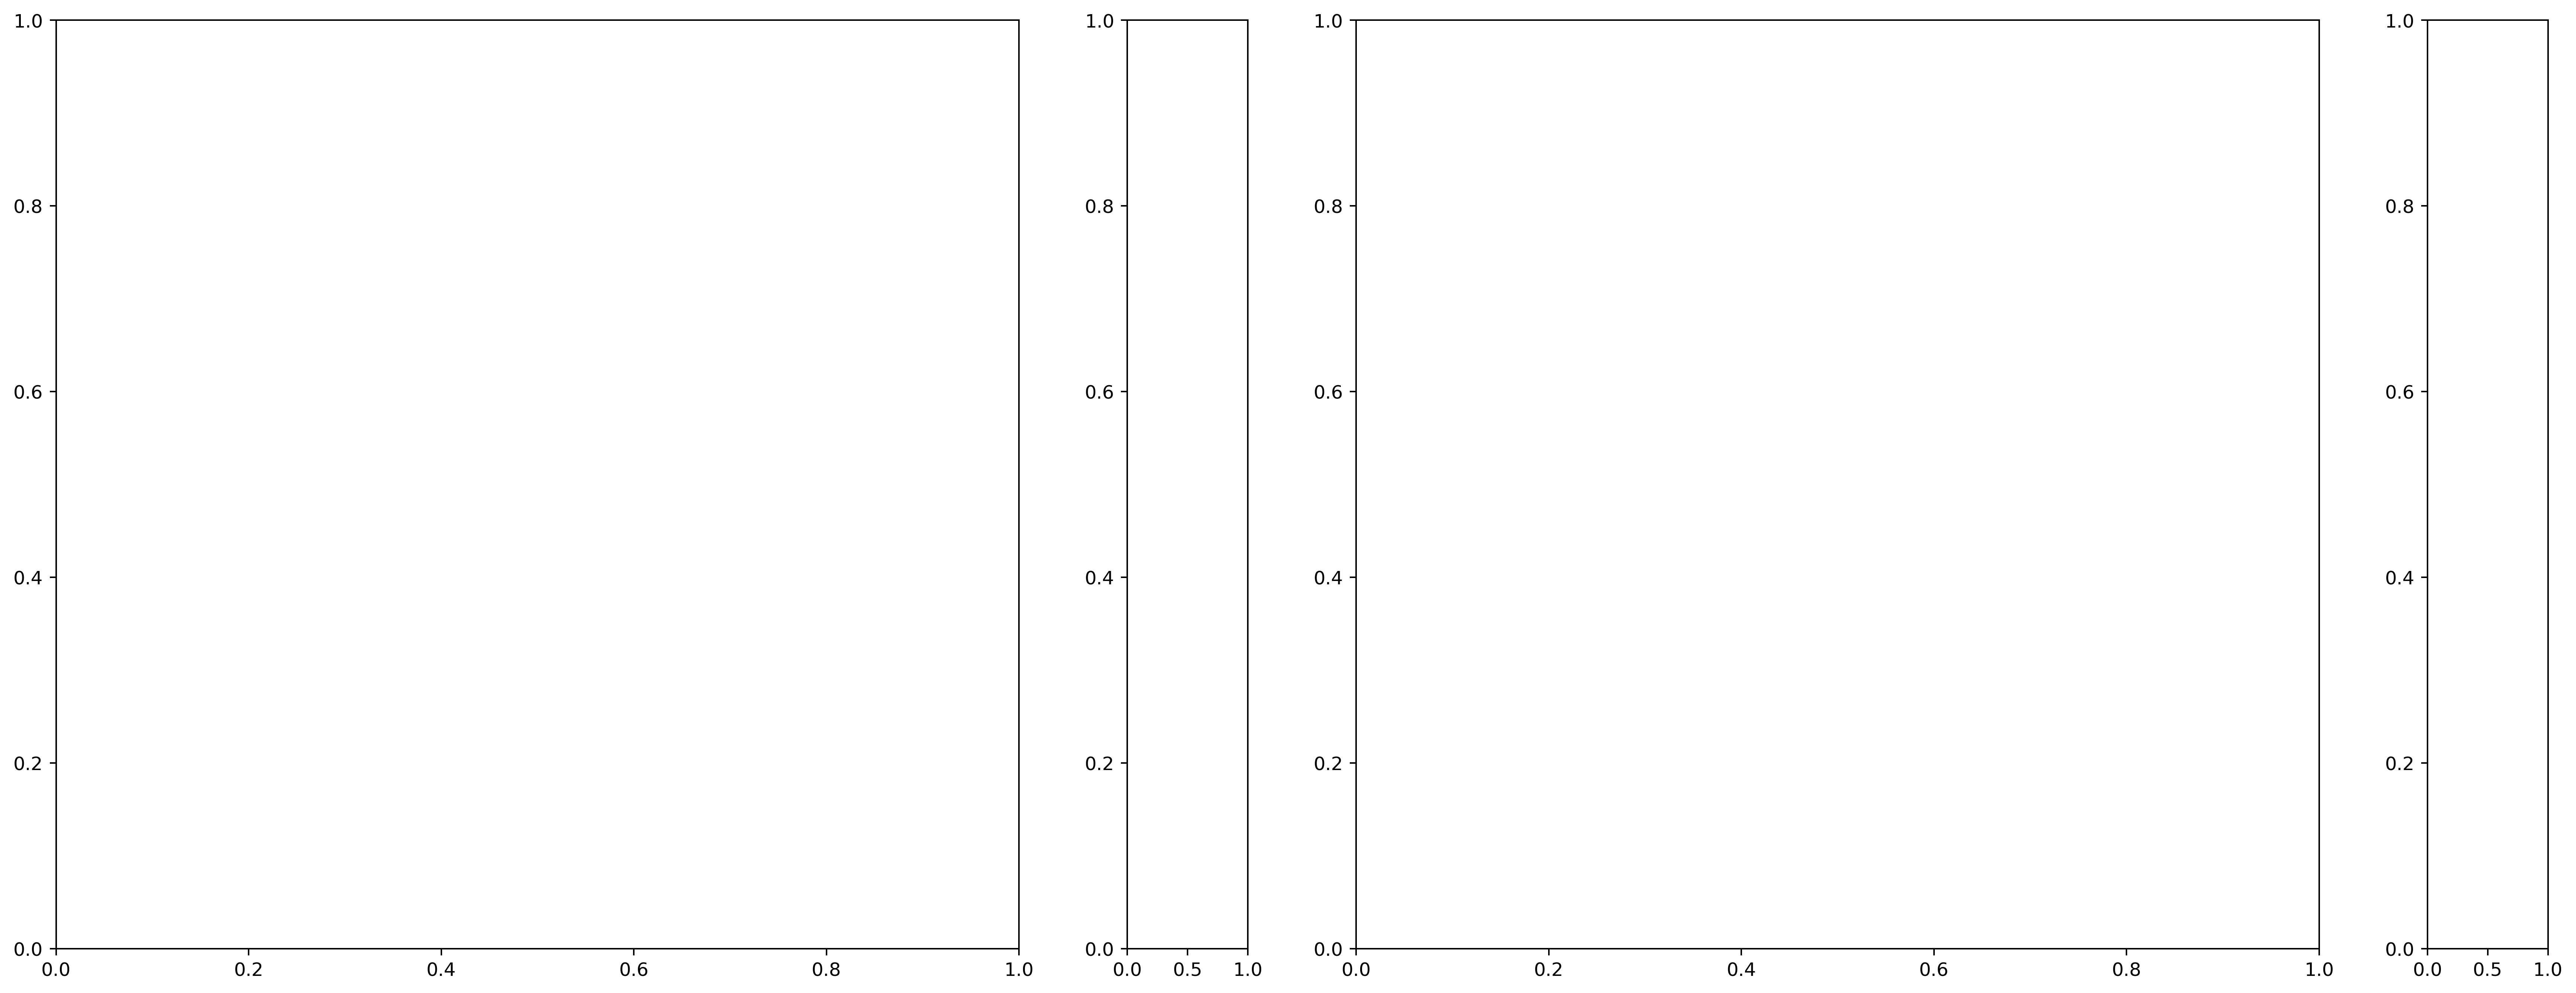

In [70]:
fig, axs = plt.subplots(1, 4, dpi=180, figsize=(12*2, 9*1), gridspec_kw={'width_ratios': [4, 0.5]*2})
axs = axs.flatten()
axs = [(axs[i], axs[i+1]) for i in range(0, len(axs), 2)]
plot('beta_Il2#Egr2', dpi=100, size=20, fig=fig, axes=axs[0])
plot('beta_Il2#Egr2', dpi=100, size=20, fig=fig, axes=axs[1], with_expr=True)
# plot('Egr2', dpi=100, size=20, fig=fig, axes=axs[2])
# plot('Il2', dpi=100, size=20, fig=fig, axes=axs[3])
# plot('beta_Egr2', dpi=100, size=20, fig=fig, axes=axs[4])
# plot('Il2#Egr2', dpi=100, size=20, fig=fig, axes=axs[5])
plt.show()
